In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import warnings  
warnings.filterwarnings('ignore')

/kaggle/input/malicious-and-benign-websites/dataset.csv


# Overview
The goal of this notebook is to see if a simple neural network can be trained to classify a website as malicious or benign. 

In [2]:
dataset = pd.read_csv('../input/malicious-and-benign-websites/dataset.csv')
dataset.describe(include='all')

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781,1781.000000,1781.000000,1781,1780,969.000000,1781,1781,1781,1781,...,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
unique,1781,NaN,NaN,9,239,NaN,49,182,891,594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,B0_1164,NaN,NaN,UTF-8,Apache,NaN,US,CA,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,676,386,NaN,1103,372,127,139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,56.961258,11.111735,NaN,NaN,11726.927761,NaN,NaN,NaN,NaN,...,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,NaN,27.555586,4.549896,NaN,NaN,36391.809051,NaN,NaN,NaN,NaN,...,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,NaN,16.000000,5.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,NaN,39.000000,8.000000,NaN,NaN,324.000000,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,NaN,49.000000,10.000000,NaN,NaN,1853.000000,NaN,NaN,NaN,NaN,...,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,NaN,68.000000,13.000000,NaN,NaN,11323.000000,NaN,NaN,NaN,NaN,...,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000


## Data Analysis and Preparation

Let's begin by having a look at the data - cleaning it up where appropriate. 

In [3]:
dataset.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


The URL column is a unique identifier so we may as well remove that. 

In [4]:
dataset.drop('URL', axis =1, inplace=True)

In [5]:
# Look for null values 
print(dataset.isnull().sum())

URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
REMOTE_APP_PACKETS             0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
APP_PACKETS                    0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64


There are null values each for the DNS_QUERY_TIMES and SERVER columns, so we could easily drop these records / place a dummy value instead without affecting the data too much. The CONTENT_LENGTH column is a bit more concerning, we can't afford to drop that many records (almost half the dataset) and interpolating might distort the data somewhat. Given that there are plenty of other features, I'm choosing to drop the column.

In [6]:
dataset.drop('CONTENT_LENGTH', axis =1, inplace=True)
dataset.dropna(inplace=True)
print(dataset.isnull().sum())

URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64


Looking at the data there are several categorical features (WHOIS_COUNTRY, SERVER etc.). For simplicity we'll ignore these features in our network.

In [7]:
dataset.drop(['CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', ], axis =1, inplace=True)

Let's have a look at the correlations of the remaining features.

In [8]:
corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1,0.918098,-0.038159,-0.0396963,-0.0461736,-0.0264163,-0.0419671,-0.0334806,-0.0146276,-0.0266523,-0.0419671,-0.068453,0.162641
NUMBER_SPECIAL_CHARACTERS,0.918098,1,-0.0373227,-0.042554,-0.0469611,-0.0238958,-0.0399387,-0.0304671,-0.0142756,-0.0240788,-0.0399387,-0.0500667,0.28115
TCP_CONVERSATION_EXCHANGE,-0.038159,-0.0373227,1,0.55518,0.331057,0.457324,0.997798,0.990871,0.865585,0.458705,0.997798,0.349877,-0.0402757
DIST_REMOTE_TCP_PORT,-0.0396963,-0.042554,0.55518,1,0.210198,0.780243,0.558601,0.591173,0.313333,0.781216,0.558601,0.259919,-0.0829994
REMOTE_IPS,-0.0461736,-0.0469611,0.331057,0.210198,1,0.0231239,0.361087,0.304712,0.17166,0.0253217,0.361087,0.548413,-0.0788005
APP_BYTES,-0.0264163,-0.0238958,0.457324,0.780243,0.0231239,1,0.445828,0.46901,0.0744558,0.999992,0.445828,0.0122082,-0.0112807
SOURCE_APP_PACKETS,-0.0419671,-0.0399387,0.997798,0.558601,0.361087,0.445828,1,0.9893,0.857496,0.447453,1,0.410876,-0.0345086
REMOTE_APP_PACKETS,-0.0334806,-0.0304671,0.990871,0.591173,0.304712,0.46901,0.9893,1,0.88055,0.470412,0.9893,0.355648,-0.0330292
SOURCE_APP_BYTES,-0.0146276,-0.0142756,0.865585,0.313333,0.17166,0.0744558,0.857496,0.88055,1,0.0753195,0.857496,0.215227,-0.0439493
REMOTE_APP_BYTES,-0.0266523,-0.0240788,0.458705,0.781216,0.0253217,0.999992,0.447453,0.470412,0.0753195,1,0.447453,0.0162014,-0.0110238


Looks like there are some highly correlated features in there. A lot of these make sense - for example longer URLs will probably contain more special characters. Let's remove some of the more highly correlated features. 

In [9]:
dataset.drop(['TCP_CONVERSATION_EXCHANGE','URL_LENGTH','APP_BYTES','SOURCE_APP_PACKETS','REMOTE_APP_PACKETS','SOURCE_APP_BYTES','REMOTE_APP_BYTES'], axis = 1, inplace=True)
corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

,NUMBER_SPECIAL_CHARACTERS,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_PACKETS,DNS_QUERY_TIMES,Type
NUMBER_SPECIAL_CHARACTERS,1,-0.042554,-0.0469611,-0.0399387,-0.0500667,0.28115
DIST_REMOTE_TCP_PORT,-0.042554,1,0.210198,0.558601,0.259919,-0.0829994
REMOTE_IPS,-0.0469611,0.210198,1,0.361087,0.548413,-0.0788005
APP_PACKETS,-0.0399387,0.558601,0.361087,1,0.410876,-0.0345086
DNS_QUERY_TIMES,-0.0500667,0.259919,0.548413,0.410876,1,0.0686061
Type,0.28115,-0.0829994,-0.0788005,-0.0345086,0.0686061,1


That looks a lot better, let's examine the data to see if it's suitable to use in the model.

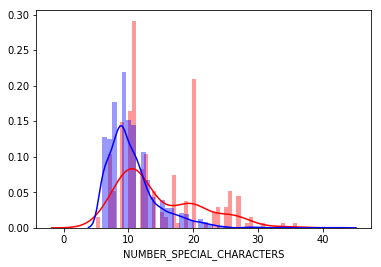

In [10]:
import seaborn as sns
sns.distplot(dataset.loc[dataset['Type'] == 1]['NUMBER_SPECIAL_CHARACTERS'], bins = 50, color='red')
sns.distplot(dataset.loc[dataset['Type'] == 0]['NUMBER_SPECIAL_CHARACTERS'], bins = 50, color='blue')

The red bars are the malicious websites - there are some definite odd spikes there so this looks promising.

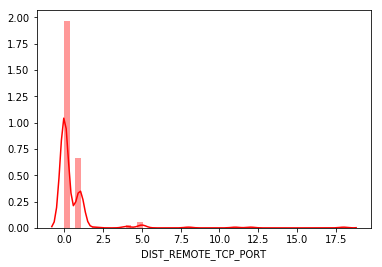

In [11]:
sns.distplot(dataset.loc[dataset['Type'] == 1]['DIST_REMOTE_TCP_PORT'], bins = 50, color='red')


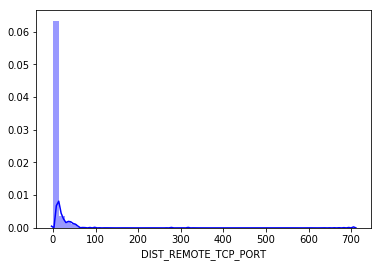

In [12]:
sns.distplot(dataset.loc[dataset['Type'] == 0]['DIST_REMOTE_TCP_PORT'], bins = 50, color='blue')

In [13]:
print(dataset.loc[dataset['Type'] == 0]['DIST_REMOTE_TCP_PORT'].value_counts())

0      763
3      151
2       75
4       67
6       60
      ... 
53       1
317      1
31       1
50       1
708      1
Name: DIST_REMOTE_TCP_PORT, Length: 66, dtype: int64


In [14]:
print(dataset.loc[dataset['Type'] == 1]['DIST_REMOTE_TCP_PORT'].value_counts())

0     153
1      52
5       4
4       2
18      1
12      1
11      1
8       1
2       1
Name: DIST_REMOTE_TCP_PORT, dtype: int64


Looks like malicious websites generally have don't have a port associated (0 isn't a valid port?) not sure if we can infer anything from this or nor but we'll leave it in for now. It may be worth removing it later and observing the affect on the model.

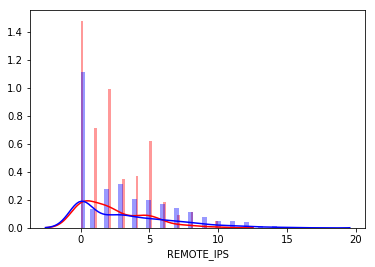

In [15]:
sns.distplot(dataset.loc[dataset['Type'] == 1]['REMOTE_IPS'], bins = 50, color='red')
sns.distplot(dataset.loc[dataset['Type'] == 0]['REMOTE_IPS'], bins = 50, color='blue')

REMOTE_IPS is described as 'this variable has the total number of IPs connected to the honeypot'. Looks like malicious websites have a slightly lower grouping of remote IPs connected than benign.

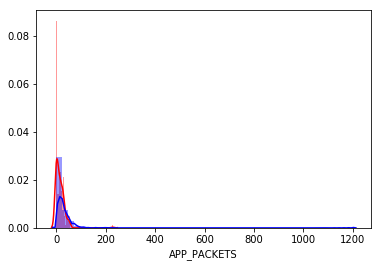

In [16]:
sns.distplot(dataset.loc[dataset['Type'] == 1]['APP_PACKETS'], bins = 50, color='red')
sns.distplot(dataset.loc[dataset['Type'] == 0]['APP_PACKETS'], bins = 50, color='blue')

Hard to infer much from this, looks like there might be an outlier. APP_PACKETS is '...the total number of IP packets generated during the communication between the honeypot and the server'. So a large number of these could be a technical error.

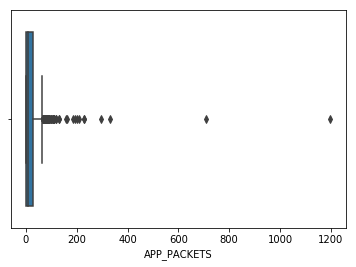

In [17]:
sns.boxplot(dataset['APP_PACKETS'])

Given there's a couple of values definitely way out of the normal range we'll remove these. 

In [18]:
dataset = dataset[((dataset.APP_PACKETS - dataset.APP_PACKETS.mean()) / dataset.APP_PACKETS.std()).abs() < 3]

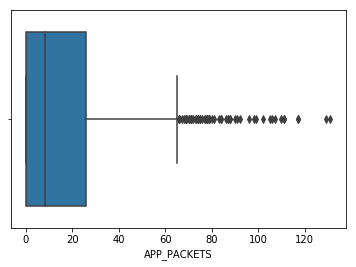

In [19]:
sns.boxplot(dataset['APP_PACKETS'])

That looks a lote better. Let's have a look at the histogram again.

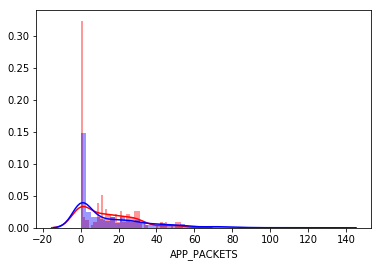

In [20]:
sns.distplot(dataset.loc[dataset['Type'] == 1]['APP_PACKETS'], bins = 50, color='red')
sns.distplot(dataset.loc[dataset['Type'] == 0]['APP_PACKETS'], bins = 50, color='blue')

In [21]:
print(dataset.loc[dataset['Type'] == 1]['DIST_REMOTE_TCP_PORT'].value_counts())

0     153
1      52
5       4
4       2
12      1
11      1
8       1
2       1
Name: DIST_REMOTE_TCP_PORT, dtype: int64


In [22]:
print(dataset.loc[dataset['Type'] == 0]['DIST_REMOTE_TCP_PORT'].value_counts())

0     760
3     151
2      74
4      67
6      59
     ... 
59      1
60      1
67      1
73      1
31      1
Name: DIST_REMOTE_TCP_PORT, Length: 63, dtype: int64


Nothing too obvious. Again the spike at 0, these might correlate with the 0 on remote IPs. 

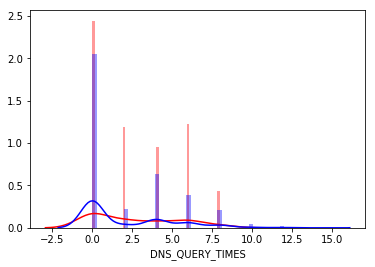

In [23]:
sns.distplot(dataset.loc[dataset['Type'] == 1]['DNS_QUERY_TIMES'], bins = 50, color='red')
sns.distplot(dataset.loc[dataset['Type'] == 0]['DNS_QUERY_TIMES'], bins = 50, color='blue')

In [24]:
print(dataset['DNS_QUERY_TIMES'].value_counts())

0.0     974
4.0     307
6.0     210
2.0     137
8.0     105
10.0     19
12.0     12
14.0      2
9.0       1
Name: DNS_QUERY_TIMES, dtype: int64


The graph is slightly misleading - there aren't actually any negative values (thankfully). Again nothing too obvious but we'll leave it our model. 

## The Model

Given our reduced dataset, let's start trying to create a model. We'll start by scaling the data then splitting it into a test and train set. We'll then use a simple logistic regression model to baseline the accuracy then see if we can perform better using a nerual network.

In [25]:
# Scale data then split
from sklearn import preprocessing
# Separate into train and test as well as features and predictor
X = dataset.drop('Type',axis=1) #Predictors
y = dataset['Type']
X = preprocessing.scale(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

In [26]:
# Method for evaluating results
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
def calculateScores(y_test, predictions):
    accuracy = 100*accuracy_score(y_test, predictions)
    precision = 100*precision_score(y_test, predictions)
    recall = 100*recall_score(y_test, predictions)
    f1 = 100*f1_score(y_test, predictions)
    print (' Accuracy  %.2f%%' % accuracy)
    print (' Precision %.2f%%'% precision)
    print (' Recall    %.2f%%'% recall)
    print (' F1        %.2f%%'% f1)
    print('Confusion Matrix')
    print(confusion_matrix(y_test,predictions))
    return {'Accuracy':accuracy, 'F1': f1}

In [27]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(solver='lbfgs')
model = reg.fit(X_train, y_train)
predictions = model.predict(X_test)
scores = calculateScores(y_test, predictions)

 Accuracy  86.25%
 Precision 33.33%
 Recall    5.80%
 F1        9.88%
Confusion Matrix
[[454   8]
 [ 65   4]]


So our base model has 86% accueracy, but pretty poor precision and recall. From the confusion matrix we can see that while it's pretty good at predicting benign websites, it's poor at predicting the malicious ones, which makes it pretty useless if we wanted to use it in the real world. 

Let's see if we can improve this with a neural network. We'll use the standard SciKit learn class, starting off by using all the default values, before attempting to optimise it by adjusting its parameters.

In [28]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)
scores = calculateScores(y_test, predictions)

 Accuracy  88.32%
 Precision 61.29%
 Recall    27.54%
 F1        38.00%
Confusion Matrix
[[450  12]
 [ 50  19]]


Straight away that's a small improvement on the simple model, it is better at classifying the malicious websites, as seen in the confusion matrix and the F1 score.

Let's have a play with the parameters to see if this can be improved.

In [29]:
def predict( X_train, y_train, **kwargs):
    mlp = MLPClassifier(**kwargs, random_state=1)
    mlp.fit(X_train, y_train)
    return mlp.predict(X_test)

In [30]:
def calculateScoresNoOutput(y_test, predictions):
    accuracy = 100*accuracy_score(y_test, predictions)
    precision = 100*precision_score(y_test, predictions)
    recall = 100*recall_score(y_test, predictions)
    f1 = 100*f1_score(y_test, predictions)
    return {'Accuracy':accuracy, 'F1': f1}

In [31]:
# Let's try the different solvers
solvers = ['lbfgs', 'sgd', 'adam']
results = []
for solver in solvers:
    result_dict = calculateScoresNoOutput(y_test, predict(X_train, y_train, solver=solver))
    result_dict['Solver'] = solver
    results.append(result_dict)
df = pd.DataFrame(results, columns = ['Solver','Accuracy', 'F1'])
df

,Solver,Accuracy,F1
0,lbfgs,88.700565,52.380952
1,sgd,87.947269,17.948718
2,adam,88.323917,38.000000


Looks like the lbfgs solver is the best, with highest accuray and F1 scores. We'll use that from now on. 

In [32]:
# Generalise attempting different values
def try_different_values(values, column_name, X_train, y_train, **kwargs):
    results = []
    for value in values:
        kwargs[column_name] = value
        result_dict = calculateScoresNoOutput(y_test, predict(X_train, y_train, **kwargs))
        result_dict[column_name] = value
        results.append(result_dict)
    df = pd.DataFrame(results, columns = [column_name,'Accuracy', 'F1'])
    return df

In [33]:
activations = ['identity', 'logistic', 'tanh', 'relu']
try_different_values(activations, 'activation', X_train, y_train, solver='lbfgs')

,activation,Accuracy,F1
0,identity,86.440678,16.279070
1,logistic,90.207156,57.377049
2,tanh,89.077213,55.384615
3,relu,88.700565,52.380952


Another improvement using the logistic activation. Let's try adjusting the regularisation

In [34]:
alphas = []
for i in range(5,40):
     alphas.append(1/(2**i))
alpha_df = try_different_values(alphas, 'alpha', X_train, y_train, solver='lbfgs', activation='logistic')

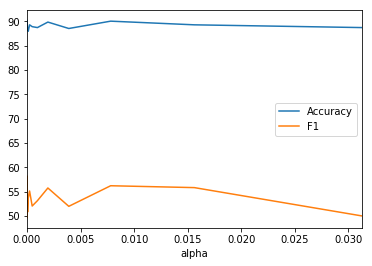

In [35]:
alpha_df.set_index('alpha', inplace=True)
alpha_df.plot()

In [36]:
print(alpha_df.loc[alpha_df['Accuracy'].idxmax()])
print(alpha_df.loc[alpha_df['F1'].idxmax()])

Accuracy    90.207156
F1          56.666667
Name: 7.450580596923828e-09, dtype: float64
Accuracy    89.453861
F1          58.208955
Name: 4.76837158203125e-07, dtype: float64


The regularisation parameter doesn't seem to change much. Let's save it and try the batch size.

In [37]:
# Store alpha
alpha= 4.76837158203125e-07

In [38]:
batch_sizes = [2 ** e for e in range(10)]
batch_df = try_different_values(batch_sizes, 'batch_size', X_train, y_train, solver='lbfgs', activation='logistic', alpha=alpha)

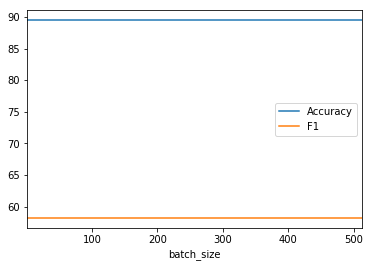

In [39]:
batch_df.set_index('batch_size', inplace=True)
batch_df.plot()

Batch size doesn't seem to be affecting the accuracy - let's move on to the hidden layers. 

In [40]:
layers = []
for i in range (1,25):
    layers+= [(i)]
layers_df = try_different_values(layers, 'hidden_layer_sizes', X_train, y_train, solver='lbfgs', activation='logistic', alpha=alpha)

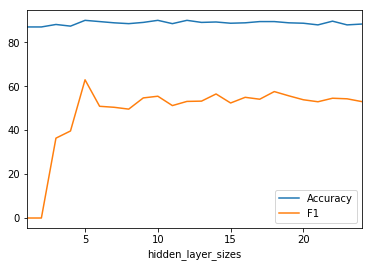

In [41]:
layers_df.set_index('hidden_layer_sizes', inplace=True)
layers_df.plot()

In [42]:
print(layers_df.loc[layers_df['Accuracy'].idxmax()])
print(layers_df.loc[layers_df['F1'].idxmax()])

Accuracy    90.018832
F1          62.937063
Name: 5, dtype: float64
Accuracy    90.018832
F1          62.937063
Name: 5, dtype: float64


There's a definite advatage at 5 hidden layers. What if we add a second layer. 

In [43]:
layers = []
for i in range (1,15):
    for j in range(1,15):
        layers+= [(i,j)]
layers_df = try_different_values(layers, 'hidden_layer_sizes', X_train, y_train, solver='lbfgs', activation='logistic', alpha=alpha)

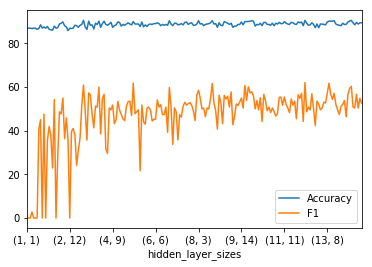

In [44]:
layers_df.set_index('hidden_layer_sizes', inplace=True)
layers_df.plot()

In [45]:
#layers_df = layers_df.reset_index()
layers_df = layers_df.reset_index()
print(layers_df.iloc[[layers_df['Accuracy'].idxmax()]])
print(layers_df.iloc[[layers_df['F1'].idxmax()]])

   hidden_layer_sizes   Accuracy       F1
33             (3, 6)  90.583804  60.9375
    hidden_layer_sizes   Accuracy         F1
162            (12, 9)  90.583804  62.121212


So the best result with another hidden layer isn't better than a single hidden layer of size. We'll try a third just to see.

In [46]:
layers = []
for i in range (1,10):
    for j in range(1,10):
        for k in range (1,10):
            layers+= [(i,j,k)]
layers_3_df = try_different_values(layers, 'hidden_layer_sizes', X_train, y_train, solver='lbfgs', activation='logistic', alpha=alpha)

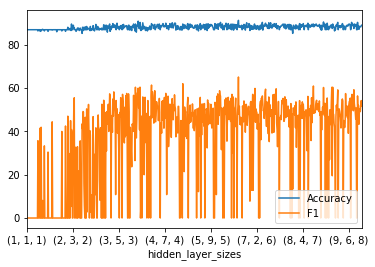

In [47]:
layers_3_df.set_index('hidden_layer_sizes', inplace=True)
layers_3_df.plot()

In [48]:
layers_3_df = layers_3_df.reset_index()
print(layers_3_df.iloc[[layers_3_df['Accuracy'].idxmax()]])
print(layers_3_df.iloc[[layers_3_df['F1'].idxmax()]])

    hidden_layer_sizes  Accuracy         F1
460          (6, 7, 2)   91.3371  65.151515
    hidden_layer_sizes  Accuracy         F1
460          (6, 7, 2)   91.3371  65.151515


## Conclusion
Looking at the final results. We've got up to 91% accuracy, with an F1 score of 65%. This is qutie good considering the rather naive neural network implementation and lazy data preparation. Whilst not the most complete implementation it does show that a neural network is a viable model for this data. 
### Future Work
A more considered approad to implementing the neural network could be considered i.e. is the lbfgs solver still the best with a three layer hidden network? The data could be better prepared and the categorical data should be included to see if it adds any value. The other issue is that there is not a large amont of data, specifically malicious websites. If more data could be collected it could help the model, and help stop any problems of overfitting.

